In [1]:
from discopy.cat import Ob


class Tree:
    """
    We can check the axioms of multicategories (coloured operads) hold. 
    
    >>> x, y = Ob('x'), Ob('y')
    >>> f, g, h = Box('f', x, [x, x]), Box('g', x, [x, y]), Box('h', x, [y, x])
    >>> assert Id(x)(f) == f == f(Id(x), Id(x))
    >>> left = f(Id(x), h)(g, Id(x), Id(x))
    >>> middle = f(g, h)
    >>> right = f(g, Id(x))(Id(x), Id(x), h)
    >>> assert left == middle == right == Tree(root=f, branches=[g, h])
    """
    def __init__(self, root, branches, _scan=True):
        if not isinstance(root, Box):
            raise TypeError()
        if not all([isinstance(branch, Tree) for branch in branches]):
            raise TypeError()
        if _scan and not root.cod == [branch.dom for branch in branches]:
            raise AxiomError()
        self.dom, self.root, self.branches = root.dom, root, branches

    @property
    def cod(self):
        if isinstance(self, Box):
            return self._cod
        else:
            return [x for x in branch.cod for branch in self.branches]

    def __repr__(self):
        return "Tree({}, {})".format(self.root, self.branches)

    def __call__(self, *others):
        if not others or all([isinstance(other, Id) for other in others]):
            return self
        if isinstance(self, Id):
            return others[0]
        if isinstance(self, Box):
            return Tree(self, list(others))
        if isinstance(self, Tree):
            lengths = [len(branch.cod) for branch in self.branches]
            ranges = [0] + [sum(lengths[:i + 1]) for i in range(len(lengths))]
            branches = [self.branches[i](*others[ranges[i]:ranges[i + 1]])
                        for i in range(len(self.branches))]
            return Tree(self.root, branches, _scan=False)
        raise NotImplementedError()

    @staticmethod
    def id(dom):
        return Id(dom)

    def __eq__(self, other):
        return self.root == other.root and self.branches == other.branches


class Box(Tree):
    """
    Implements generators of free operads, i.e. the nodes in the trees.
    
    >>> n, d, v, vp, np, s = Ob('N'), Ob('D'), Ob('V'), Ob('VP'), Ob('NP'), Ob('S')
    >>> Caesar, crossed = Box('Caesar', n, []), Box('crossed', v, []),
    >>> the, Rubicon = Box('the', d, []), Box('Rubicon', n, [])
    >>> VP, NP, S = Box('VP', vp, [n, v]), Box('NP', np, [d, n]), Box('S', s, [vp, np])
    >>> sentence = S(VP(Caesar, crossed), NP(the, Rubicon))
    """
    def __init__(self, name, dom, cod):
        if not (isinstance(dom, Ob) and isinstance(cod, list)
                and all([isinstance(x, Ob) for x in cod])):
            raise TypeError
        self.name, self.dom, self._cod = name, dom, cod
        Tree.__init__(self, self, [], _scan=False)

    def __repr__(self):
        return "Box('{}', {}, {})".format(self.name, self.dom, self._cod)

    def __hash__(self):
        return hash(repr(self))

    def __eq__(self, other):
        if isinstance(other, Box):
            return self.dom == other.dom and self.cod == other.cod \
                        and self.name == other.name
        if isinstance(other, Tree):
            return other.root == self and other.branches == []
        
class Id(Box):
    def __init__(self, dom):
        self.dom, self._cod = dom, [dom]
        Box.__init__(self, "Id({})".format(dom), dom, dom)

    def __repr__(self):
        return "Id({})".format(self.dom)


class Algebra:
    def __init__(self, ob, ar, cod=Tree):
        self.cod, self.ob, self.ar = cod, ob, ar

    def __call__(self, tree):
        if isinstance(tree, Id):
            return self.cod.id(ob[tree])
        if isinstance(tree, Box):
            return self.ar[tree]
        return self.ar[tree.root](*[self(branch) for branch in tree.branches])

In [2]:
x, y = Ob('x'), Ob('y')
f, g, h = Box('f', x, [x, x]), Box('g', x, [x, y]), Box('h', x, [y, x])
assert Id(x)(f) == f == f(Id(x), Id(x))
left = f(Id(x), h)(g, Id(x), Id(x))
middle = f(g, h)
right = f(g, Id(x))(Id(x), Id(x), h)
assert left == middle == right == Tree(root=f, branches=[g, h])

In [3]:
n, d, v, vp, np, s = Ob('N'), Ob('D'), Ob('V'), Ob('VP'), Ob('NP'), Ob('S')
Caesar, crossed = Box('Caesar', n, []), Box('crossed', v, []),
the, Rubicon = Box('the', d, []), Box('Rubicon', n, [])
VP, NP, S = Box('VP', vp, [n, v]), Box('NP', np, [d, n]), Box('S', s, [vp, np])
sentence = S(VP(Caesar, crossed), NP(the, Rubicon))

In [4]:
from discopy.cat import Quiver
ob = Quiver(lambda ty: x)
ar = Quiver(lambda node: f if node in [VP, NP, S] else Box(node.name, x, []))
F = Algebra(ob, ar)
tree0 = f(f(f(ar[Caesar], ar[crossed]), ar[the]), ar[Rubicon])
tree1 = f(f(ar[Caesar], ar[crossed]), f(ar[the], ar[Rubicon]))
assert F(sentence) == tree1 != tree0

### Interface with discopy.monoidal

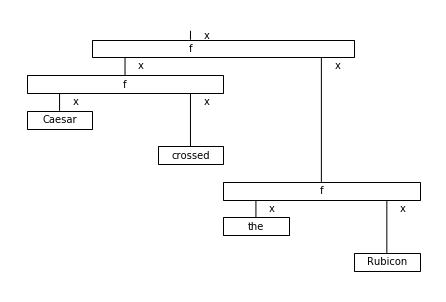

In [5]:
from discopy import monoidal
from discopy.monoidal import Ty, Diagram

def tree2diagram(tree):
    if isinstance(tree, Id):
        return Diagram.id(Ty(tree.dom))
    if isinstance(tree, Box):
        return monoidal.Box(tree.name, Ty(tree.dom), Ty().tensor(*map(Ty, tree.cod)))
    else:
        cod = monoidal.Ty().tensor(*map(Ty, tree.root.cod))
        return monoidal.Box(tree.root.name, Ty(tree.dom), cod) \
            >> Diagram.id().tensor(*[tree2diagram(branch)
                                              for branch in tree.branches])
tree2diagram(tree1).draw()

### Interface with NLTK (1)

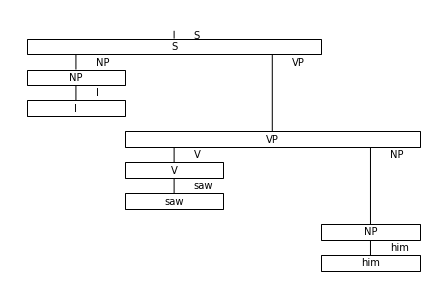

In [6]:
import nltk
def from_nltk(tree):
    if isinstance(tree, str):
        return Box(tree, Ob(tree), [])
    else:
        cod = [Ob(branch) if isinstance(branch, str) else Ob(branch.label()) for branch in tree]
        return Box(tree.label(), Ob(tree.label()), cod)(*[from_nltk(branch) for branch in tree])


t = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
tree2diagram(from_nltk(t)).draw()

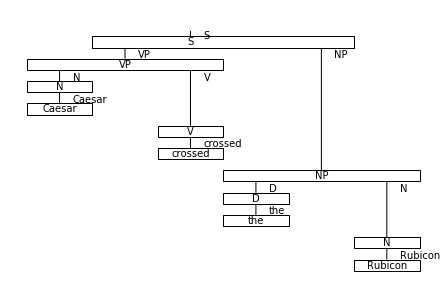

In [7]:
from nltk import CFG
from nltk.parse import RecursiveDescentParser
grammar = CFG.fromstring("""
S -> VP NP
NP -> D N
VP -> N V
N -> 'Caesar'
V -> 'crossed'
D -> 'the'
N -> 'Rubicon'""")

rd = RecursiveDescentParser(grammar)
for x in rd.parse('Caesar crossed the Rubicon'.split()):
    tree2diagram(from_nltk(x)).draw()

### Interface with NLTK (2)

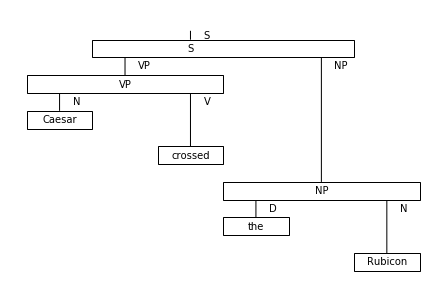

In [8]:
def from_nltk(tree):
    """
    Assumes that tree is generated from a lexicalised CFG
    """
    branches, cod = [], []
    for branch in tree:
        if isinstance(branch, str):
            return Box(branch, Ob(tree.label()), [])
        else:
            branches += [from_nltk(branch)]
            cod += [Ob(branch.label())]
    root = Box(tree.label(), Ob(tree.label()), cod)
    return root(*branches)

parse = next(rd.parse('Caesar crossed the Rubicon'.split()))
tree2diagram(from_nltk(parse)).draw()

In [9]:
assert from_nltk(parse) == sentence

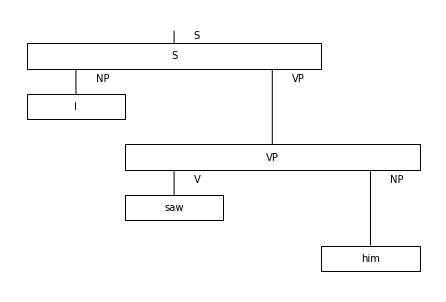

In [10]:
tree2diagram(from_nltk(t)).draw()